## Tarea 6: Reconocimiento facial

Mytzi Yael Munguía Cuatlayotl

El reconocimiento facial, en general tiene 3 etapas:

1. Detección de rostros: Detectar los rostros y sus posiciones en una imagen.
2. Alineación de los rostros: Selección de los rostros y su transformación para homogeneizar el tamaño de las imágenes de rostros
3. Extracción de características

Para facilitar este ejercicio, nosotros sólo nos concentraremos en la tarea de extracción de características. Es decir, nuestra red sólo será alimentada con fotos de rostros.


## 1. Primera parte: Reconocimiento de atributos  

**Importamos las librerias**

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, SGD

**A partir del código proporcionado en clase, hice unas modificaciones para quitar algunos atributos que no eran de mucho interés**

Los atributos que quite son: 
3 atractivo,
15 grosero, 
35 usando aretes, 
36 usando sombrero, 
38 usando collar y 
39 usando corbata 

In [2]:
# Configurar la precisión de impresión para NumPy
np.set_printoptions(precision=4)

# Columnas a eliminar
columnas_a_eliminar = [3, 15, 35, 36, 38, 39]

# Eliminar el doble espacio entre algunos datos de la tabla
with open("C:/Users/REC/Desktop/javier/list_attr_celeba.txt", 'r') as f:
    print("skipping : " + f.readline())
    print("skipping headers : " + f.readline())
    # Abre un nuevo archivo en modo escritura para escribir los datos procesados
    with open('attr_celeba_prepa.txt', 'w') as newf:
        for line in f:
            # Elimina espacios duplicados y escribe la línea procesada
            new_line = ' '.join(line.split())
            newf.write(new_line)
            newf.write('\n')

# Leé el archivo procesado en un DataFrame de Pandas
df = pd.read_csv('attr_celeba_prepa.txt', sep=' ', header=None)

# Imprime algunas partes del DataFrame para verificar los resultados (antes)
print("------------------Antes------------------")
print(df[0].head())
print(df.iloc[:, 1:].head())
print("------------------Fin------------------")

# Reemplaza -1 por 0 en el DataFrame
df = df.replace(-1, 0)

# Eliminación de columnas antes mencionadas
df = df.drop(df.columns[columnas_a_eliminar], axis=1)

# Guardar el DataFrame modificado en un nuevo archivo
df.to_csv('attr_celeba_prepared.txt', index=False, header=False, sep=' ')

# Imprime algunas partes del DataFrame para verificar los resultados después de eliminar columnas y reemplazar valores)
print("------------------Resultados------------------ ")
print(df[0].head())
print(df.iloc[:, 1:].head())
print("------------------Fin------------------")


skipping : 202599

skipping headers : 5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young 

------------------Antes------------------
0    000001.jpg
1    000002.jpg
2    000003.jpg
3    000004.jpg
4    000005.jpg
Name: 0, dtype: object
   1   2   3   4   5   6   7   8   9   10  ...  31  32  33  34  35  36  37  \
0  -1   1   1  -1  -1  -1  -1  -1  -1  -1  ...  -1   1   1  -1   1  -1   1   
1  -1  -1  -1   1  -1  -1  -1   1  -1  -1  ...  -1   1  -1  -1  -1  -1  -1   
2  -1  -1  -1  -1  -1  -1   1  -1  -1  -1  ...  -1  -1  -1   1  -1  -1  -1   
3  -1  -1   1  -1  -1  -1  -1  -1  -1  

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(34,), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(34,), dtype=tf.int64, name=None))>


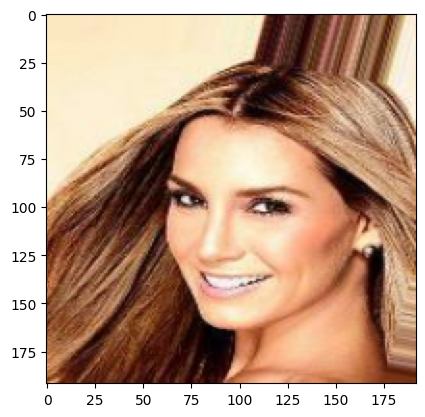

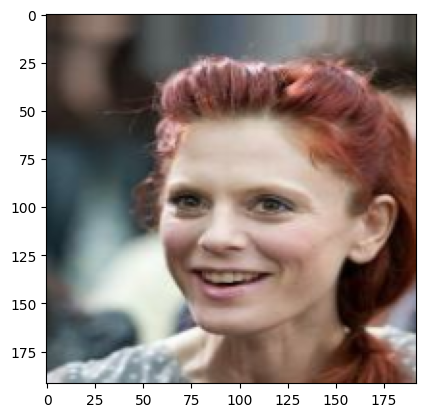

In [3]:
# Crea un conjunto de datos de TensorFlow a partir de un DataFrame de Pandas
files = tf.data.Dataset.from_tensor_slices(df[0])  # Obtiene la primera columna
attributes = tf.data.Dataset.from_tensor_slices(df.iloc[:, 1:].to_numpy())  # obtiene los atributos
data = tf.data.Dataset.zip((files, attributes))  # Combina los dos anteriores

# Imprime información sobre el conjunto de datos
print(data)

# Directorio que contiene las imágenes. PD: no olvidar el / al final de la ruta
path_to_images = "C:/Users/REC/Desktop/javier/img_align_celeba/"

# Procesamiento de cada archivo del conjunto de datos
def process_file(file_name, attributes):
    image = tf.io.read_file(path_to_images + file_name)  # Leé el archivo de imagen
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica la imagen
    image = tf.image.resize(image, [192, 192])  # Cambia el tamaño de la imagen
    image /= 255.0  # Normaliza los valores de píxeles al rango [0, 1] IMPORTANTE
    return image, attributes

# Aplica la función
labeled_images = data.map(process_file)

# Imprime información sobre el conjunto de datos procesado
print(labeled_images)

# Visualiza las dos primeras imágenes del conjunto de datos
for image, attri in labeled_images.take(2):
    plt.imshow(image)
    plt.show()


## 1.1 Red neuronal para la identificación de carcateristicas faciales (atributos)

In [4]:
# Aplica la función de procesamiento y definimos los lotes
batch_size = 35
labeled_images = data.map(process_file).batch(batch_size)

# Dividimos el conjunto de datos en entrenamiento y prueba
num_train = int(len(df) * 0.7) #El 30% de los datos se usarán para evaluar la red y el 70% para entrenarla
num_test = len(df) - num_train

epochs_steps = num_train // batch_size
test_steps = num_test // batch_size

data_train = labeled_images.take(num_train)
data_test = labeled_images.skip(num_train)

# Forma de entrada del modelo
ih, iw = 192, 192
input_shape = (ih, iw,3)

**Entrenamiento del modelo**

In [5]:
# Creación del modelo
model = Sequential()

# Capa convolucional con 68 filtros de 3x3 y función de activación ReLU
model.add(Conv2D(34, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
# Capa de reducción de muestreo utilizando MaxPooling
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(98, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa densa con 64 neuronas y función de activación ReLU
#model.add(Flatten())
#model.add(Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.1)))
#model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Capa densa final con 34 neuronas y función de activación sigmoide
model.add(Dense(34))
model.add(Activation('sigmoid'))

# Compilar el modelo
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

# Imprimir resumen del modelo
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 190, 34)      952       
                                                                 
 activation (Activation)     (None, 190, 190, 34)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 95, 95, 34)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 93, 64)        19648     
                                                                 
 activation_1 (Activation)   (None, 93, 93, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                

In [6]:
history = model.fit(data_train,
                    epochs=10,
                    batch_size=35,
                    verbose=1,
                    validation_data=data_test,
                    validation_steps=test_steps)

Epoch 1/10


5789/5789 [==============================] - 1651s 285ms/step - loss: 0.2963 - accuracy: 0.0235
Epoch 2/10
5789/5789 [==============================] - 1625s 281ms/step - loss: 0.2557 - accuracy: 0.0267
Epoch 3/10
5789/5789 [==============================] - 1649s 285ms/step - loss: 0.2415 - accuracy: 0.0264
Epoch 4/10
5789/5789 [==============================] - 1653s 286ms/step - loss: 0.2305 - accuracy: 0.0267
Epoch 5/10
5789/5789 [==============================] - 1649s 285ms/step - loss: 0.2208 - accuracy: 0.0270
Epoch 6/10
5789/5789 [==============================] - 1660s 287ms/step - loss: 0.2131 - accuracy: 0.0273
Epoch 7/10
5789/5789 [==============================] - 1644s 284ms/step - loss: 0.2062 - accuracy: 0.0266
Epoch 8/10
5789/5789 [==============================] - 1678s 290ms/step - loss: 0.1995 - accuracy: 0.0269
Epoch 9/10
5789/5789 [==============================] - 1643s 284ms/step - loss: 0.1934 - accuracy: 0.0265
Epoch 10/10
5789/5789 [============

In [9]:
model.save('red_att.h5')